In [1]:
import numpy as np
from numba import njit
from functools import partial
import plotly.graph_objects as go
import talib 
import pandas as pd
import vectorbt as vbt
import vectorbt as vbt
from vectorbt.utils.colors import adjust_opacity
from vectorbt.utils.enum_ import map_enum_fields
from vectorbt.base.reshape_fns import broadcast, flex_select_auto_nb, to_2d_array
from vectorbt.portfolio.enums import SizeType, Direction, NoOrder, OrderStatus, OrderSide
from vectorbt.portfolio import nb
import sys
import os
function_essential_path = r"C:\Users\Jordi\Desktop\Environement de developement\Trading_Dev_Stratégie_Environement\FunctionEssential"
function_s_score_path = r'C:\Users\Jordi\Desktop\Environement de developement\Trading_Dev_Stratégie_Environement\Indicateur'
sys.path.append(function_essential_path)
sys.path.append(function_s_score_path)
import utils as us
import s_score as score

KeyboardInterrupt: 

In [ ]:
##FONCTION##

In [ ]:
##FONCTION LOGIQUE SIGNALS##

def entries_trades(close, sscore_ajuster, rsi_period, bb_period, seuil_score, overbought_rsi, oversell_rsi):
    long = np.full_like(close, False, dtype=bool)
    short = np.full_like(close, False, dtype=bool)
    # Calcul du RSI avec TA-Lib
    rsi = talib.RSI(close[:, 0], timeperiod=rsi_period)
    upper_band, middle_band, lower_band = talib.BBANDS(close[:, 0], timeperiod=bb_period)

    # Boucle sur les valeurs de close
    for idx in range(len(close)):
        if (rsi[idx] >= overbought_rsi) and (close[idx] > upper_band[idx]):
            if sscore_ajuster[idx] > seuil_score:
                short[idx] = True 

        if (rsi[idx] <= oversell_rsi) and (close[idx] < lower_band[idx]):
            if sscore_ajuster[idx] < -seuil_score:
                long[idx] = True 

    return long, short




def exits_trades(long, short, close, s_score_ajuster, stop_loss, s_score_out):
    # Initialisation with the same shape as long and short
    long_exit = np.zeros_like(long, dtype=np.float64)
    short_exit = np.zeros_like(short, dtype=np.float64)

    # Parcourir chaque colonne de long (donc aussi short)
    for col in range(long.shape[1]):
        for idx in range(len(close)):
            if long[idx, col]:  # Vérifie si on entre en position long
                SL = close[idx, col] * (1 - stop_loss)  # Stop loss basé sur close (1D)
                for j in range(idx + 1, len(close)):
                    if close[j, col] <= SL:
                        long_exit[j, col] = SL
                        break
                    if s_score_ajuster[j, col] >= -s_score_out:
                        long_exit[j, col] = close[j, col]
                        break

            if short[idx, col]:  # Vérifie si on entre en position short
                SL = close[idx, col] * (1 + stop_loss)
                for j in range(idx + 1, len(close)):
                    if close[j, col] >= SL:
                        short_exit[j, col] = SL
                        break
                    if s_score_ajuster[j, col] <= s_score_out:
                        short_exit[j, col] = close[j, col]
                        break

    return long_exit, short_exit




In [ ]:
##INDICATEUR FACTORY##

Entry = vbt.IndicatorFactory(
    class_name="entries_trades",
    input_names=["close","sscore_ajuster"],
    param_names=["rsi_period","bb_period","seuil_score","overbought_rsi","oversell_rsi"],
    output_names=["long","short"],
).from_apply_func(entries_trades)

Exit = vbt.IndicatorFactory(
    class_name="exits_trades",
    input_names=["long","short","close","s_score_ajuster"],
    param_names=["stop_loss","s_score_out"],
    output_names=["long","short"],
).from_apply_func(exits_trades)

In [ ]:
@njit
def pre_sim_func_nb(c):
    entry_price = np.full(c.target_shape[1], np.nan, dtype=np.float64)  
    return (entry_price,)

@njit
def order_func_nb(c, entry_price, long, short, long_exit,short_exit, size):
    price_now = nb.get_elem_nb(c, c.close)
    entry_long_now = nb.get_elem_nb(c, long)
    entry_short_now = nb.get_elem_nb(c, short)


    if entry_long_now:
        if c.position_now == 0:
            return nb.order_nb(
                size[c.col], 
                price=price_now,
                direction=Direction.LongOnly,
                fees=0.001
            )
        elif c.position_now < 0:
            return nb.order_nb(
                -size[c.col],  
                price=price_now,
                direction=Direction.ShortOnly,
                fees=0.0005
            )  

    if entry_short_now:
        if c.position_now == 0:
            return nb.order_nb(
                size[c.col], 
                price=price_now,
                direction=Direction.ShortOnly,
                fees=0.001
            )
        elif c.position_now > 0:
            return nb.order_nb(
                -size[c.col],  
                price=price_now,
                direction=Direction.LongOnly,
                fees=0.0005
            )

    if c.position_now > 0:
        long_exit_now = nb.get_elem_nb(c, long_exit)
        if long_exit_now != 0:
            return nb.order_nb(
                -size[c.col],
                price=long_exit_now,
                direction=Direction.LongOnly,
                fees=0.0005
            )

    if c.position_now < 0:
        short_exit_now = nb.get_elem_nb(c, short_exit)
        if short_exit_now != 0:
            return nb.order_nb(
                -size[c.col],
                price=short_exit_now,
                direction=Direction.ShortOnly,
                fees=0.0005
            )
       

    return NoOrder

@njit
def post_order_func_nb(c, entry_price):
    if c.order_result.status == OrderStatus.Filled:
        entry_price[c.col] = c.order_result.price

In [ ]:
##CLASS STRATEGIE##

class Strategie():

    def __init__(self,data,tickers,frequence):
        self.data = data
        self.tickers = tickers
        self.frequences = frequence
        self.stop_loss = None
        self.s_score_out = None
        self.sscore = None
        self.rsi_period = None
        self.bb_period = None
        self.sscore_seuil = None
        self.overbuy = None
        self.oversell = None



    def set_params_strategie(self,sl,s_score_out,sscore,rsi_period,bb_period,sscore_seuil,overbuy,oversell):
        self.stop_loss = sl
        self.s_score_out = s_score_out
        self.sscore = sscore
        self.rsi_period = rsi_period
        self.bb_period = bb_period
        self.sscore_seuil = sscore_seuil
        self.overbuy = overbuy
        self.oversell = oversell


    def backtest(self):

        entries_long_df = pd.DataFrame()   
        entries_short_df = pd.DataFrame()
        exits_long_df = pd.DataFrame()
        exits_short_df = pd.DataFrame()
        close_df = pd.DataFrame()
        datetime_df = pd.DataFrame()

        for ticker in self.tickers:

            data = self.data[ticker]
            datetime = data.reset_index()['Datetime']
            s_score_ajuster = self.sscore[ticker]['adjusted_s_scores_vol']
            
            trades = Entry.run(
                data['close'],
                s_score_ajuster,
                self.rsi_period,
                self.bb_period,
                self.sscore_seuil,
                self.overbuy,
                self.oversell
            )

            exit = Exit.run(
                trades.long,
                trades.short,
                data['close'],
                s_score_ajuster,
                self.stop_loss,
                self.s_score_out
            )

            us.print_trades(0,trades.long,trades.short,None,None,data)

            entries_long_df[ticker] = trades.long.reset_index(drop=True)
            entries_short_df[ticker] = trades.short.reset_index(drop=True)
            exits_long_df[ticker] = exit.long.reset_index(drop=True)
            exits_short_df[ticker] = exit.short.reset_index(drop=True)
            close_df[ticker] = data['close'].reset_index(drop=True)
            datetime_df[ticker] = datetime.reset_index(drop=True)

            

        size = np.array([600000]*len(self.tickers))
        exits_long_df = exits_long_df.astype(np.float64).fillna(0)
        exits_short_df = exits_short_df.astype(np.float64).fillna(0)
        s_score_ajuster = np.asarray(s_score_ajuster, dtype=np.float64).reshape(-1,1)
        portfolio = vbt.Portfolio.from_order_func(
            close_df,  
            order_func_nb,  
            entries_long_df.values,  
            entries_short_df.values,  
            exits_long_df.values,
            exits_short_df.values,
            size,  
            freq=self.frequences,  
            init_cash=100000,  # Ajout du capital initial
            pre_sim_func_nb=pre_sim_func_nb,  
            post_order_func_nb=post_order_func_nb,  
            broadcast_named_args=dict(  
                long=entries_long_df.values,  
                short=entries_short_df.values,  
                exits_long_df=exits_long_df.values,  
                exits_short_df=exits_short_df.values,  
                size=size  
            )
        )
        us.rapport_backtest(portfolio,close_df,datetime_df,self.tickers)
        return portfolio
    


    def optimize(self,s_score_ajuster,close,fitness_func,choice,params1,params2,stop_loss_opti,seuil_out_opti,rsi_period,bb_period):
         
        if choice == 1:


            combinaison=[]
            stop_loss = []
            seuil_out = []
            for i in params1:
                for j in params2:
                    combinaison.append((i,j))
                    seuil_out.append(i)
                    stop_loss.append(j)

            trades = Entry.run(close,s_score_ajuster,rsi_period,bb_period,[3],[70],[30])
            exit = Exit.run(
                trades.long,
                trades.short,
                close,
                s_score_ajuster,
                stop_loss,
                seuil_out
            )
            long = trades.long
            short = trades.short
            long_exit = exit.long
            short_exit = exit.short


            long = long.reset_index(drop=True)
            short = short.reset_index(drop=True)
            long_exit = long_exit.reset_index(drop=True)
            short_exit = short_exit.reset_index(drop=True)
            
            close = close.reset_index(drop=True)
            close = pd.DataFrame(close)  
            #close = close.iloc[:, :len(stop_loss)]

            s_score_ajuster = np.tile(s_score_ajuster.values.reshape(-1, 1), len(stop_loss))




            capital = 100000  
            size = np.array([(0.05 * capital) / (0.02 * close.iloc[0, i]) for i in range(close.shape[1])])
            size = np.array([size[0]] * len(stop_loss))
            long = np.tile(long.values, (len(stop_loss), 1)).T
            short = np.tile(short.values, (len(stop_loss), 1)).T


            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,  
                long,  
                short,  
                long_exit.values,
                short_exit.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  # Ajout du capital initial
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=long,  
                    short=short,  
                    exits_long_df=long_exit.values,  
                    exits_short_df=short_exit.values,  
                    size=size  
                )
            )
            

            perf = us.get_heatmap(portfolio,combinaison,fitness_func)
            # us.get_3d_surface_metrics(2,portfolio,combinaison,fitness_func,"seuil_out","sl %",30,90)
            param1,param2,metrics = us.get_best_param(perf)
            return param1,param2


        if choice == 2:

            combinaison=[]
            for i in params1:
                for j in params2:
                    combinaison.append((i,j))

            print(params1.shape)
            print(params2.shape)
            trades = Entry.run(
                close,
                s_score_ajuster,
                params1,
                params2,
                [3],[70],[30],
                param_product=True)


            exit = Exit.run(
                trades.long,
                trades.short,
                close,
                s_score_ajuster,
                stop_loss_opti,
                seuil_out_opti
            )

            long = trades.long
            short = trades.short
            long_exit = exit.long
            short_exit = exit.short

            
            long = long.reset_index(drop=True)
            short = short.reset_index(drop=True)
            close = close.reset_index(drop=True)
            long_exit = long_exit.reset_index(drop=True)
            short_exit = short_exit.reset_index(drop=True)


            print(long.shape[1])


            close = np.tile(close.to_numpy().reshape(-1,1),(1,long.shape[1]))
            s_score_ajuster = np.tile(s_score_ajuster.to_numpy().reshape(-1,1),(1,long.shape[1]))


            #stop / seuil_out / s_scpore_ajuster / size 
            capital = 100000  
            size = np.array([(0.05 * capital) / (0.02 * close[0, i]) for i in range(close.shape[1])])
            size = np.array([size[0]] * long.shape[1])
            stop_loss = np.array([0.005] * long.shape[1])  
            seuil_out = np.array([1.6] * long.shape[1])

            


            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,  
                long.values,  
                short.values,  
                long_exit.values,
                short_exit.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  # Ajout du capital initial
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=long.values,  
                    short=short.values,  
                    exits_long_df=long_exit.values,  
                    exits_short_df=short_exit.values,  
                    size=size  
                )
            )
            

            perf = us.get_heatmap(portfolio,combinaison,fitness_func)
            us.get_3d_surface_metrics(2,portfolio,combinaison,fitness_func,"Period RSI","Period BB",30,90)
            param1,param2,metrics = us.get_best_param(perf)
            return param1,param2
        
        if choice == 3:

            combinaison=[]
            rsi_period=[]
            bb_period=[]
            seuil_s_score = []
            for i in params1:
                for j in params2:
                    combinaison.append((i,j))

            print(params1.shape)
            print(params2.shape)
            trades = Entry.run(close,s_score_ajuster,14,20,[3],params1,params2,param_product=True)

            long = trades.long
            short = trades.short

            
            long = long.reset_index(drop=True)
            short = short.reset_index(drop=True)
            close = close.reset_index(drop=True)


            print(long.shape[1])


            close = np.tile(close.to_numpy().reshape(-1,1),(1,long.shape[1]))
            s_score_ajuster = np.tile(s_score_ajuster.to_numpy().reshape(-1,1),(1,long.shape[1]))


            #stop / seuil_out / s_scpore_ajuster / size 
            capital = 100000  
            size = np.array([(0.05 * capital) / (0.02 * close[0, i]) for i in range(close.shape[1])])
            size = np.array([size[0]] * long.shape[1])
            stop_loss = np.array([0.005] * long.shape[1])  
            seuil_out = np.array([0] * long.shape[1])

            


            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,
                long.values,  
                short.values,  
                stop_loss,
                s_score_ajuster,
                seuil_out,  
                size,  
                freq=self.frequences,
                init_cash=100000,
                pre_sim_func_nb=pre_sim_func_nb,
                post_order_func_nb=post_order_func_nb,
                broadcast_named_args=dict(
                    long=long.values,
                    short=short.values,
                    stop_loss=stop_loss,  
                    seuil_out=seuil_out,
                    size=size 
                )
            )

            perf = us.get_heatmap(portfolio,combinaison,fitness_func)
            us.get_3d_surface_metrics(2,portfolio,combinaison,fitness_func,"overbuy","oversell",30,90)
            param1,param2,metrics = us.get_best_param(perf)
            return param1,param2
        



    def wfa(self,period_OOS, period_IOS):
 
        close_df = pd.DataFrame()
        for ticker in self.tickers:

            data = self.data[ticker]
            cycle = us.generate_wf_cycles(data, period_IOS, period_OOS)
            print(cycle)
            close = data['close']
            close_df[ticker] = close
            s_score_ajuster = self.sscore[ticker]["adjusted_s_scores_vol"]
            seuil_out_opti = -10
            for i in range(len(cycle)):

                close_IOS = data["close"].iloc[cycle[i][0]:cycle[i][1]]
                close_OOS = data["close"].iloc[cycle[i][2]:cycle[i][3]]

                s_score_ajuster_IOS = s_score_ajuster.iloc[cycle[i][0]:cycle[i][1]].reset_index(drop=True)
                s_score_ajuster_OOS = s_score_ajuster.iloc[cycle[i][2]:cycle[i][3]].reset_index(drop=True)
                
                if seuil_out_opti == -10:
                    seuil_out_opti = 0
                    stop_loss_opti = 0.01

                rsi_period = np.arange(10, 16, 1)
                bb_period = np.arange(15, 26, 1)
                rsi_period_opti, bb_period_opti = self.optimize(s_score_ajuster_IOS,close_IOS,2,2,rsi_period,bb_period,stop_loss_opti,seuil_out_opti,0,0)
                
                seuil_out = np.round(np.arange(0.5, -0.6, -0.1), 1)
                stop_loss = np.arange(0.009, 0.016, 0.001)
                seuil_out_opti, stop_loss_opti = self.optimize(s_score_ajuster_IOS,close_IOS,2,1,seuil_out,stop_loss,0,0,rsi_period_opti,bb_period_opti)
                print(seuil_out_opti)
                print(stop_loss_opti)

                #premiere itération on save la période IOS pour afficher l'entierté de mon jeu de donnée 
                if i == 0:

                    trades = Entry.run(
                        close_IOS,
                        s_score_ajuster_IOS,
                        rsi_period_opti,
                        bb_period_opti,
                        3,70,30)
                    
                    exit = Exit.run(
                        trades.long,
                        trades.short,
                        close_IOS,
                        s_score_ajuster_IOS,
                        stop_loss_opti,
                        seuil_out_opti
                    )

                    entries_long = trades.long.to_frame(name=ticker)
                    entries_short = trades.short.to_frame(name=ticker)
                    exits_long = exit.long.to_frame(name=ticker)
                    exits_short = exit.short.to_frame(name=ticker)


                trades = Entry.run(
                    close_OOS,
                    s_score_ajuster_OOS,
                    rsi_period_opti,
                    bb_period_opti,
                    3,70,30)
                
                exit = Exit.run(
                        trades.long,
                        trades.short,
                        close_OOS,
                        s_score_ajuster_OOS,
                        stop_loss_opti,
                        seuil_out_opti
                    )
                    # Concaténation des nouvelles entrées aux précédentes
                entries_long = pd.concat([entries_long, trades.long.to_frame(name=ticker)], ignore_index=True)
                entries_short = pd.concat([entries_short, trades.short.to_frame(name=ticker)], ignore_index=True)
                exits_long = pd.concat([exits_long, exit.long.to_frame(name=ticker)], ignore_index=True)
                exits_short = pd.concat([exits_short, exit.short.to_frame(name=ticker)], ignore_index=True)

                print(exits_long)


            capital = 100000   
            size = np.array([(0.05 * capital) / (0.02 * close_df.iloc[0, i]) for i in range(len(self.tickers))])
            stop_loss = np.array([0.01] * len(self.tickers))  
            take_profit = np.array([0.02] * len(self.tickers))

        
            #Si ca fonctionne pas regarde bien que les shapes soit cohérente, le type de entries long et short ca doit etre des boolean

            us.get_details_variable([close,entries_long,entries_short,exits_long,exits_short])

            portfolio = vbt.Portfolio.from_order_func(
                close,  
                order_func_nb,  
                entries_long.values,  
                entries_short.values,  
                exits_long.values,
                exits_short.values,
                size,  
                freq=self.frequences,  
                init_cash=100000,  # Ajout du capital initial
                pre_sim_func_nb=pre_sim_func_nb,  
                post_order_func_nb=post_order_func_nb,  
                broadcast_named_args=dict(  
                    long=entries_long.values,  
                    short=entries_short.values,  
                    exits_long=exits_long.values,  
                    exits_short=exits_short.values,  
                    size=size  
                )
            )
            us.get_pnl(portfolio)
            return portfolio



In [ ]:
tickers = ['GPDUSD']
DATA = us.get_data_forex(tickers,'H4')
s_score_value = {}
for ticker in tickers:
    data_traitement = DATA[ticker]
    nb_nan = data_traitement['close'].isna().sum()
    close = data_traitement['close'].dropna()
    close_without_index = close.reset_index()
    result = score.mean_reversion(close, close_without_index['Datetime'], 85, "VOL", 0.5, "EGARCH")
    result_df = pd.DataFrame({
        's_score_value': result[0],
        'adjusted_s_scores_vol': result[1],
        'theta_vals': result[2],
        'mu_vals': result[3],
        'sigma_vals': result[4]
    })
    nan_rows = pd.DataFrame([[float('nan')] * result_df.shape[1]] * nb_nan, columns=result_df.columns)
    result_df = pd.concat([result_df, nan_rows], ignore_index=True)

    s_score_value[ticker] = result_df

Estimation des paramètres OU:   0%|          | 0/36224 [00:00<?, ?it/s]

  0%|          | 0/36224 [00:00<?, ?it/s]

C:\Users\Jordi\Desktop\Environement de developement\Trading_Dev_Stratégie_Environement\Indicateur\s_score.py:31: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


Calcul de la volatilité conditionnelle: 100%|██████████| 36309/36309 [00:00<00:00, 313855.13it/s]


36308


C:\Users\Jordi\AppData\Local\Temp\ipykernel_24936\2534746778.py:18: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



[(0, 24537, 24537, 27759), (3101, 27759, 27759, 30996), (6216, 30996, 30996, 34229), (9536, 34229, 34229, 36309)]
(6,)
(11,)
66


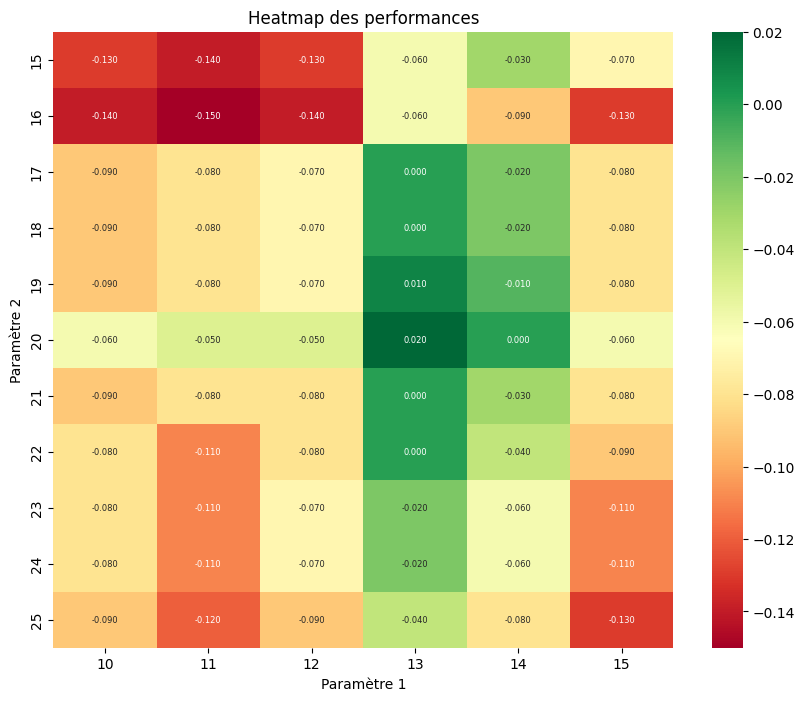

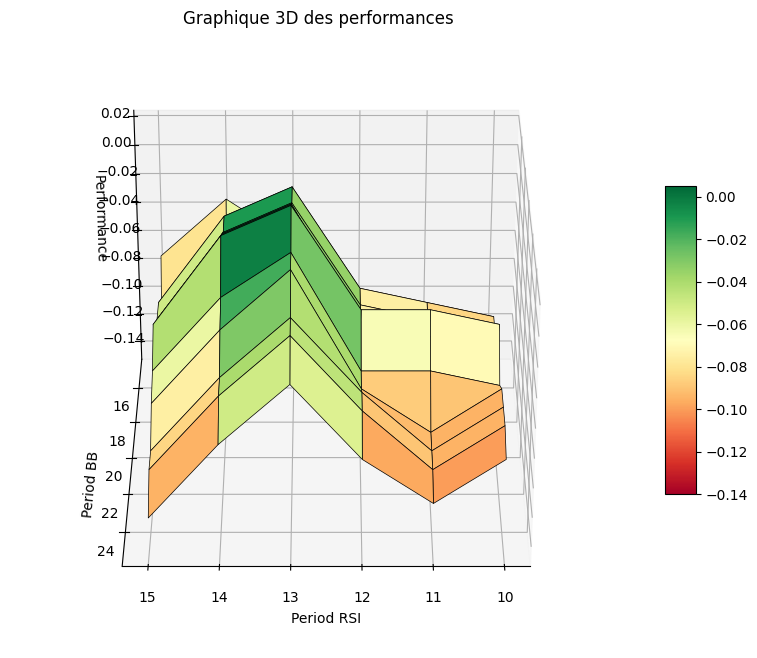

c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



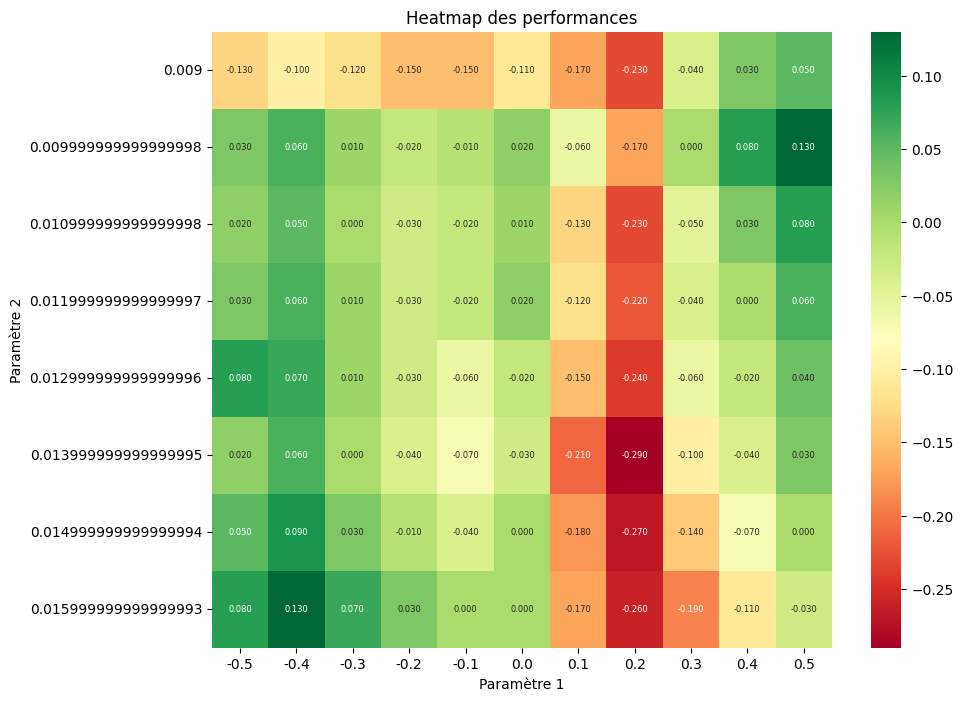

0.5
0.009999999999999998
       GPDUSD
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
...       ...
27754     0.0
27755     0.0
27756     0.0
27757     0.0
27758     0.0

[27759 rows x 1 columns]
(6,)
(11,)
66


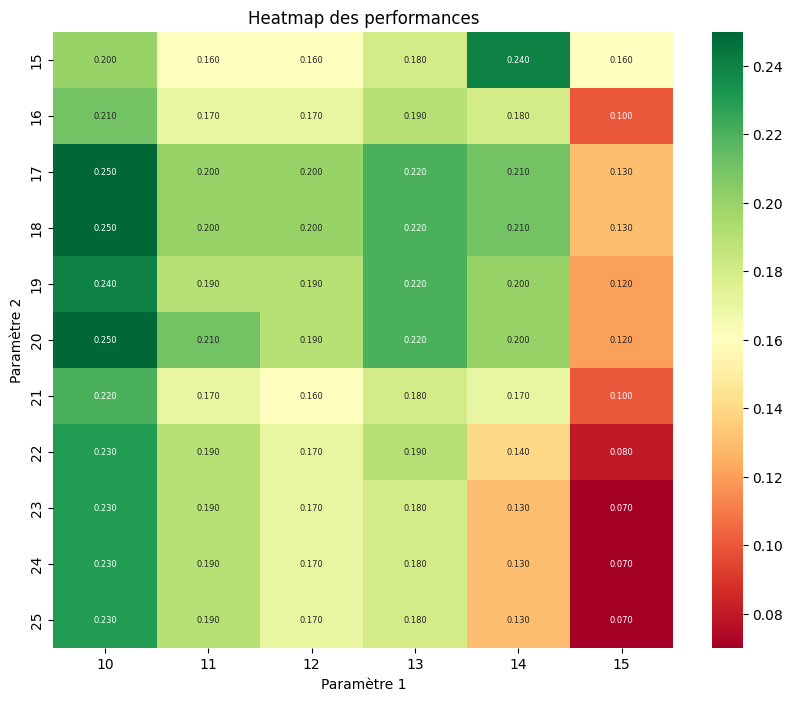

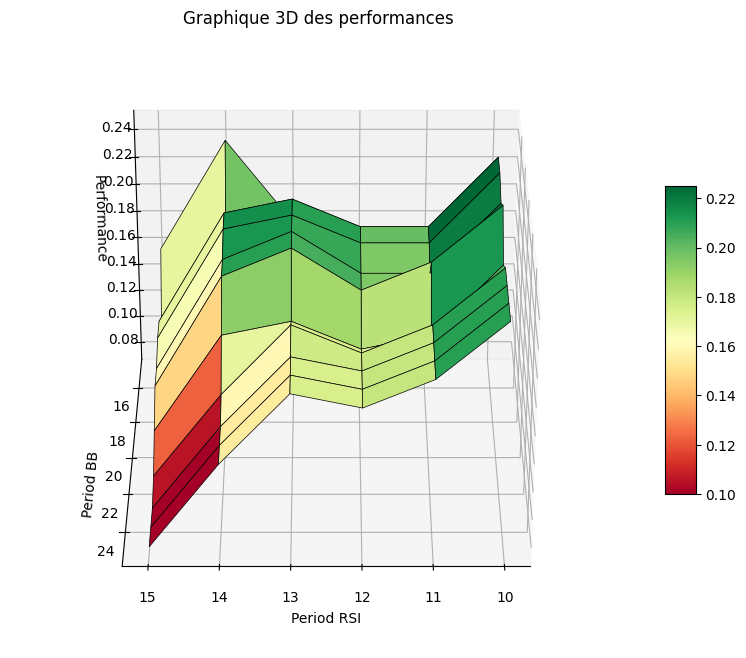

c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



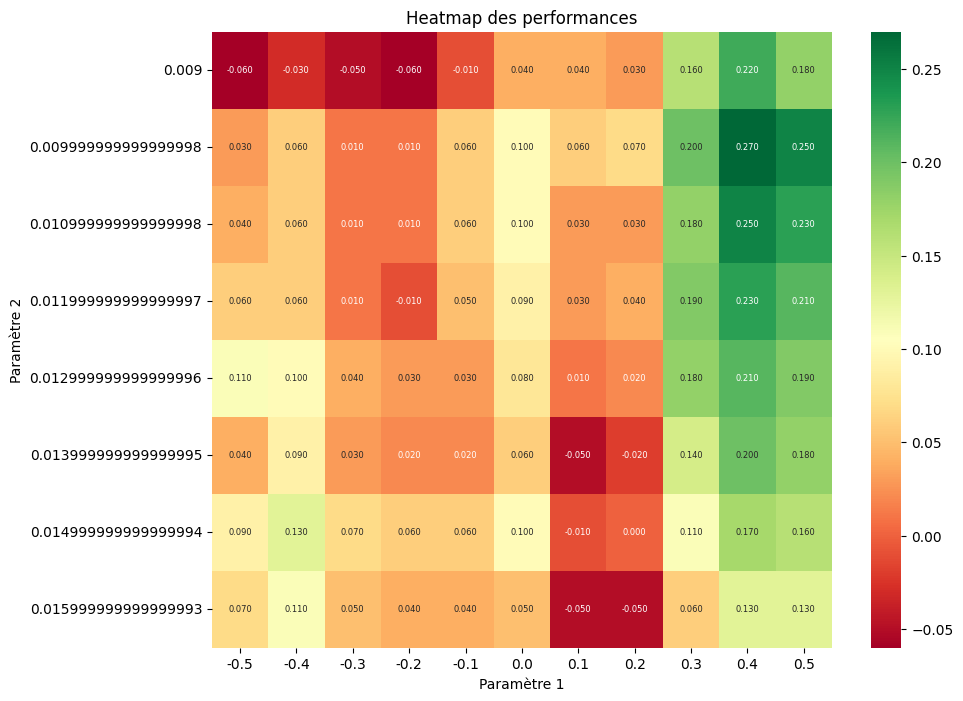

0.4
0.009999999999999998
       GPDUSD
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
...       ...
30991     0.0
30992     0.0
30993     0.0
30994     0.0
30995     0.0

[30996 rows x 1 columns]
(6,)
(11,)
66


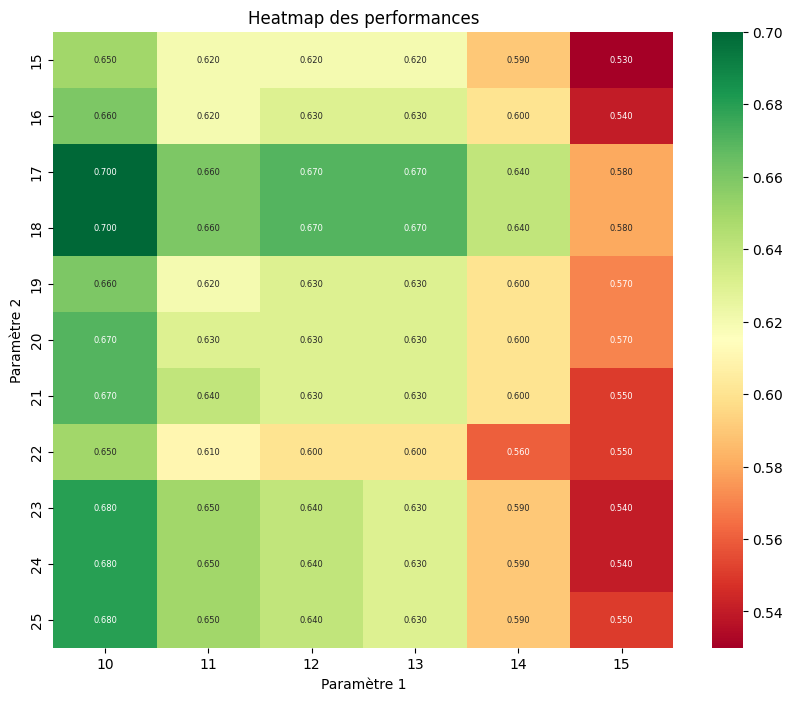

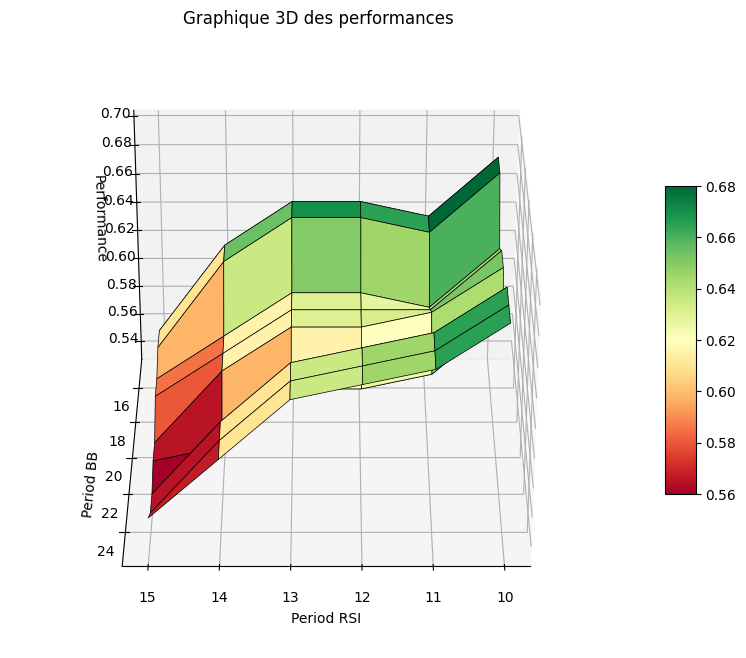

c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



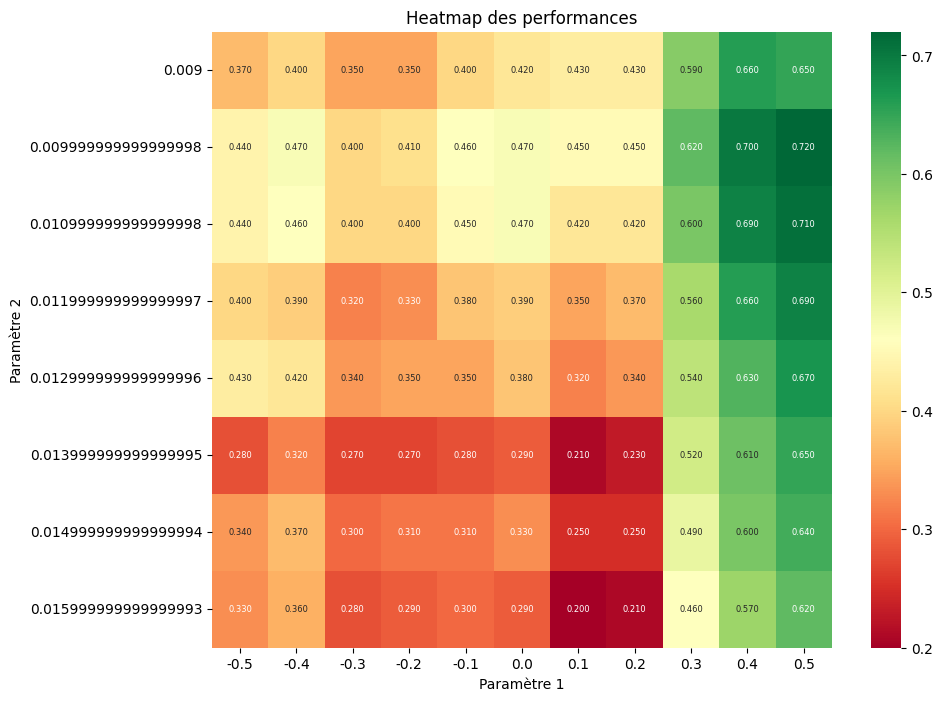

0.5
0.009999999999999998
       GPDUSD
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
...       ...
34224     0.0
34225     0.0
34226     0.0
34227     0.0
34228     0.0

[34229 rows x 1 columns]
(6,)
(11,)
66


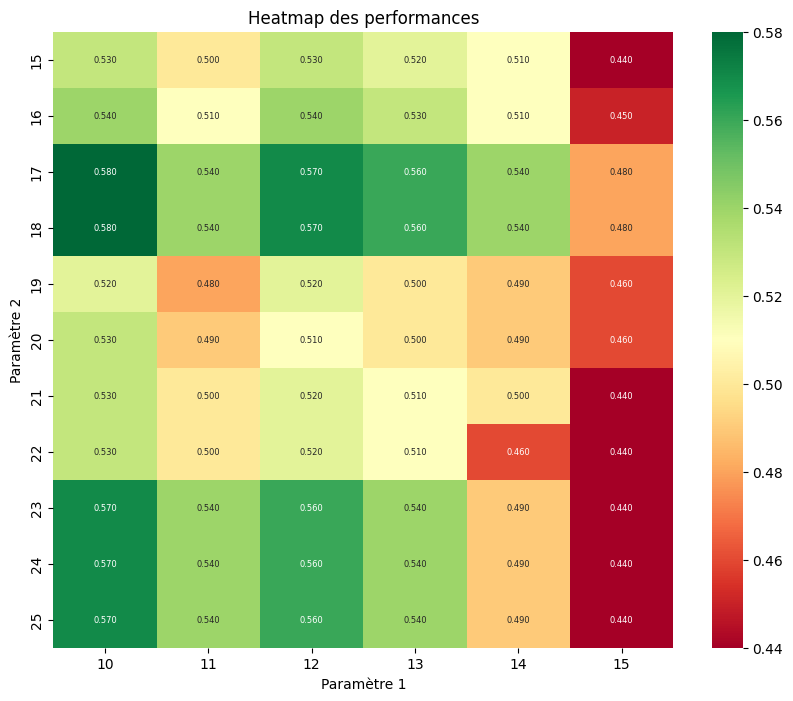

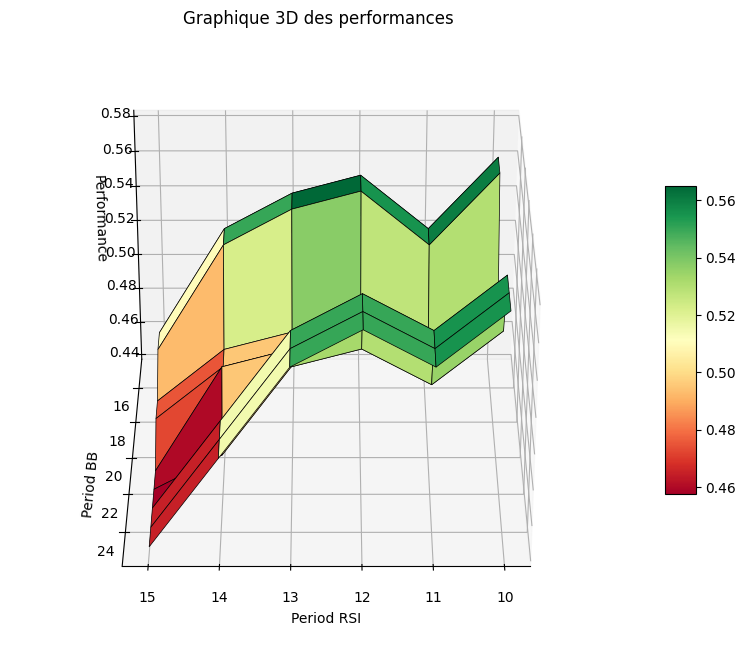

c:\Users\Jordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\vectorbt\base\indexing.py:145: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



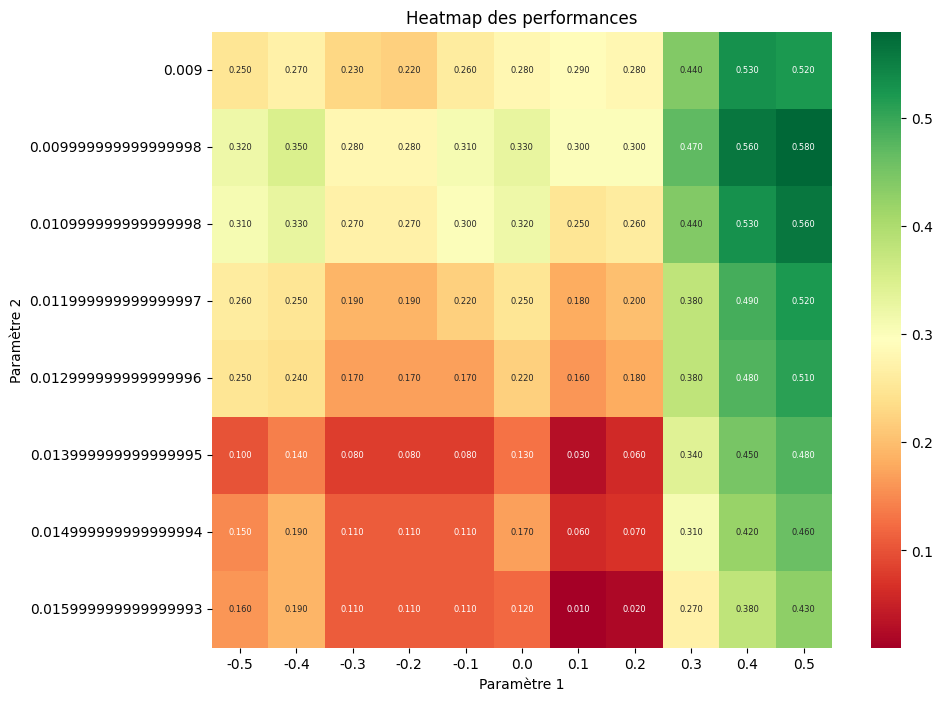

0.5
0.009999999999999998
       GPDUSD
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
...       ...
36304     0.0
36305     0.0
36306     0.0
36307     0.0
36308     0.0

[36309 rows x 1 columns]
Variable : close
Type : <class 'pandas.core.series.Series'>
Shape : (36309,)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (36309, 1)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (36309, 1)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (36309, 1)


Variable : N/A
Type : <class 'pandas.core.frame.DataFrame'>
Shape : (36309, 1)




In [ ]:
strat = Strategie(DATA,tickers,'240m')

strat.set_params_strategie(0.01,0,s_score_value,20,20,10,70,30)

strat.wfa("2Y","15Y")

# # portfolio = strat.backtest()


# s_score_ajuster = s_score_value['EURUSD']['adjusted_s_scores_vol']
# #seuil_out = np.round(np.arange(2, -1, -0.1), 1)
# #stop_loss = np.arange(0.005, 0.05, 0.002)
# rsi_period = np.arange(10, 30, 1)
# bb_period = np.arange(10, 30, 1)
# # # overbuy = np.arange(70, 90, 1)
# # # oversell = np.arange(30, 10, -1)

# strat.optimize(s_score_ajuster,DATA['EURUSD']['close'],2,2,rsi_period,bb_period,0,0)